# ORIE 5355/INFO 5370 HW 1: Survey Weighting

 - Name: Danial Ahmed
 - Net-id: da384
 - Date: 9/13/2022
 - Late days used for this assignment: 0
 - Total late days used (counting this assignment): 0
 - People with whom you discussed this assignment: 

After you finish the homework, please complete the following (short, anonymous) post-homework survey: https://forms.gle/AM1x5qEnLCvxsgrJ7

We have marked questions in <font color='blue'> blue </font>. Please put answers in black (do not change colors). You'll want to write text answers in "markdown" mode instead of code. In Jupyter notebook, you can go to Cell > Cell Type > Markdown, from the menu. Please carefully read the late days policy and grading procedure [here](https://orie5355.github.io/Fall_2022/assignments/). In that link, we also give some tips on exporting your notebook to PDF, which is required for GradeScope submission. 

A few notes about this homework:
1. This homework is purposefully heavy in using the Pandas package. Being able to explore data is an essential data science skill that you'll use throughout this class and your career -- even if the polling/politics application is not interesting to you. I encourage you to practice Pandas and learn how to use it well. Your code will NOT be graded on efficiency.
2. Some of the questions can be interpreted in multiple ways. That is always true in data science. You'll need to make judgment calls for what analysis to do. For the homework, you'll still receive full points for any "reasonable" choice. Also feel free to ask questions on EdStem. 

# Conceptual component

### 1) Reading

<font color='blue'> Please read Sections 3 and 4 (pages 6-13) here: https://www.nber.org/system/files/working_papers/w20830/w20830.pdf, and answer the following questions.

<font color='blue'> Please summarize the sections in no more than two sentences. 

<font color='blue'> Do you think it's a problem that most ratings are positive? If so, why? Answer in no more than four sentences. Please incorporate concepts discussed in class in your answer. 

### 2) Personal reflection

<font color='blue'> Think back to a time that you trained a model on data from people or gathered opinions via a survey (an informal one is fine). If you have not done that before, you may answer these questions about an article in the news that reported on public opinions or a model that you think might be in deployment at a company or organization with which you interact (for example, Amazon, google maps, etc)

<font color='blue'> Briefly summarize the scenario in no more than two sentences. 

<font color='blue'> What was the construct that you cared about/wanted to measure? What was the measurement (numerical data)? In what ways did the measurement not match the construct you cared about? Answer in no more than 4 sentences.  

<font color='blue'> What selection biases/differential non-response issues occurred and how did it affect your measurement? (If your answer is "None," explain exactly why you believe the assumptions discussed in class were met). Answer in no more than 3 sentences. 

<font color='blue'> Given what we have learned in class so far, what would you do differently if faced with the same scenario again? Answer in no more than 3 sentences. 

# Programming component

<font color='blue'> In this part of the homework, we provide you with data from a poll in Florida before the 2016 Presidential election in the United States. We also provide you with (one pollster's) estimates of who will vote in the 2016 election, made before the election. You will use this data and apply the weighting techniques covered in class.

## Preliminaries to load packages and data

In [132]:
import pandas as pd
import numpy as np
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter

In [85]:
dfpoll = pd.read_csv('polling_data_hw1.csv') # raw polling data
dfpoll.head()

,candidate,age,gender,party,race,education
0,Someone else,30-44,Male,Independent,White,College
1,Hillary Clinton,45-64,Male,Republican,Hispanic,College
2,Hillary Clinton,30-44,Male,Independent,Hispanic,College
3,Hillary Clinton,65+,Female,Democrat,White,College
4,Donald Trump,65+,Female,Republican,White,High School


In [3]:
dfdemographic = pd.read_csv('florida_proportions_hw1.csv') # proportions of population
dfdemographic.head()

,Electoral_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2
0,0.387927,party,NaN,Democrat,NaN
1,0.398788,party,NaN,Republican,NaN
2,0.213285,party,NaN,Independent,NaN
3,0.445928,gender,NaN,Male,NaN
4,0.554072,gender,NaN,Female,NaN


In [4]:
dfdemographic.tail()

,Electoral_Proportion,Demographic_Type_1,Demographic_Type_2,Demographic_1,Demographic_2
112,0.034216,race,education,Hispanic,Some College
113,0.027588,race,education,Hispanic,College
114,0.010929,race,education,Other,High School
115,0.010570,race,education,Other,Some College
116,0.015142,race,education,Other,College


dfdemographic contains estimates of likely voters in Florida in 2016. When Demographic_Type_2 is NaN, the row refers to just the marginal population percentage of the group in Demographic_1 of type Demographic_Type_1. When it is not NaN, the row has the joint distribution of the corresponding demographic groups.

For example, row 0 means that 38.7927% of the electorate is from the Democrat party. Row 113 means that 2.7588% of the electorate is Hispanic AND graduated college. 

## Part A: Raw visualization

<font color='blue'> Here, we'll visualize whether the respondents in the poll match the likely voter estimates. Create a scatter-plot where each point represents one Demographic group (for example, party-Independent), where the X axis is the Electoral_Proportion in dfdemographic, and the Y axis is the proportion in dfpoll. 

In [50]:
conn1 = sql.connect('polling_data_hw1.csv') # making a conenction to the database

In [53]:
dfdemographic['Demographic_1'].value_counts()

Democrat        14
Republican      14
Independent     14
Male            12
Female          12
18-29            8
30-44            8
45-64            8
65+              8
White            4
Black            4
Hispanic         4
Other            4
High School      1
Some College     1
College          1
Name: Demographic_1, dtype: int64

In [54]:
dfdemographic['Demographic_2'].value_counts()

High School     13
Some College    13
College         13
White            9
Black            9
Hispanic         9
Other            9
18-29            5
30-44            5
45-64            5
65+              5
Male             3
Female           3
Name: Demographic_2, dtype: int64

In [88]:
dfdemographic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Electoral_Proportion  117 non-null    float64
 1   Demographic_Type_1    117 non-null    object 
 2   Demographic_Type_2    101 non-null    object 
 3   Demographic_1         117 non-null    object 
 4   Demographic_2         101 non-null    object 
dtypes: float64(1), object(4)
memory usage: 4.7+ KB


In [17]:
poll_pop = len(dfpoll)

In [171]:
e= pd.DataFrame.from_dict(Counter(dfpoll['age']),orient='index').div(poll_pop)
# f = pd.DataFrame.from_dict(e).transpose().div(poll_pop)
e

,0
30-44,0.193772
45-64,0.303345
65+,0.280277
18-29,0.222607


In [391]:
#y-axis

poll_age_prop = pd.DataFrame.from_dict(Counter(dfpoll['age']),orient='index').div(poll_pop)

poll_gender_prop = pd.DataFrame.from_dict(Counter(dfpoll['gender']),orient='index').div(poll_pop)

poll_party_prop = pd.DataFrame.from_dict(Counter(dfpoll['party']),orient='index').div(poll_pop)

poll_race_prop = pd.DataFrame.from_dict(Counter(dfpoll['race']),orient='index').div(poll_pop)

poll_edu_prop = pd.DataFrame.from_dict(Counter(dfpoll['education']),orient='index').div(poll_pop)

poll_pro = pd.concat([poll_age_prop, poll_gender_prop,poll_party_prop,poll_race_prop,poll_edu_prop]).reset_index()
pollpro = poll_pro[poll_pro['index'] != 'Refused']#.set_index('index')
#.to_frame()
#x-axis

demo1 = dfdemographic[['Electoral_Proportion', 'Demographic_Type_1', 'Demographic_1']]
demo1.columns = ['Electoral_Proportion', 'Demographic_Type', 'Demographic']
demo1

demo2 = dfdemographic[['Electoral_Proportion', 'Demographic_Type_2', 'Demographic_2']]
demo2.columns = ['Electoral_Proportion', 'Demographic_Type', 'Demographic']
demo2

demo = pd.concat([demo1,demo2])

demopro = demo.groupby(['Demographic_Type', 'Demographic'], as_index=False)['Electoral_Proportion'].mean()
demopr = demo.groupby(['Demographic_Type', 'Demographic'])['Electoral_Proportion'].mean()

# demoprop_age = demoprop['age']
# demoprop_gender = demoprop['gender']
# demoprop_party = demoprop['party']
# demoprop_race = demoprop['race']
# demoprop_edu = demoprop['education']

# demof = pd.concat(
# [demoprop_age,
# demoprop_gender ,
# demoprop_party ,
# demoprop_race ,
# demoprop_edu ]
# )

demoprop = demopro.sort_values(by='Demographic', ascending=True,ignore_index=True)#.set_index('Demographic', inplace=True)#[['Demographic','Elecctoral Population']]
# demoprop.drop('Demographic_Type', axis=1,inplace=True)
pollprop = pollpro.sort_values(by='index', ascending=True,ignore_index=True)
pollprop.columns = ['Demographic', 'Proportions']

demopr

# demo1 = dfdemographic['Demographic_1'].value_counts().to_frame()

# demo2 = dfdemographic['Demographic_2'].value_counts().to_frame()

# demotot = demo1.join(demo2).transpose().sum()/len(dfdemographic)

# demo1, demo2, demotot, poll_prop

Demographic_Type  Demographic 
age               18-29           0.042203
                  30-44           0.070084
                  45-64           0.145452
                  65+             0.126876
education         College         0.116788
                  High School     0.133684
                  Some College    0.106671
gender            Female          0.184691
                  Male            0.148643
party             Democrat        0.138545
                  Independent     0.076173
                  Republican      0.142424
race              Black           0.052181
                  Hispanic        0.049892
                  Other           0.014093
                  White           0.268449
Name: Electoral_Proportion, dtype: float64

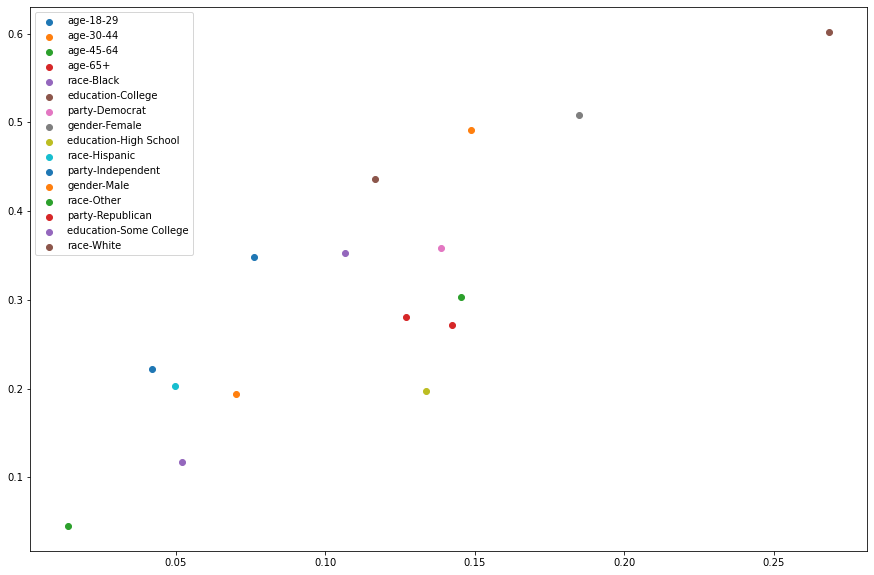

In [372]:
fig,ax = plt.subplots(figsize=(15,10))

# for i in np.arange(len(pollprop)-1):
for i in pollprop.set_index('Demographic').iterrows():
#     print(i[0])
#     for z in demoprop.set_index('Demographic').iterrows():
#         print(z[1])
        z = demoprop[demoprop['Demographic']== i[0]]
#         print(z.iloc[0][0])
        st = z.iloc[0][0] + '-' + i[0]
        plt.scatter(y=i[1], x=z['Electoral_Proportion'],label=st);

# plt.scatter(y=poll_gender_prop, x=demoprop_gender);

# plt.scatter(y=poll_party_prop[0:3], x=demoprop_party);

# plt.scatter(y=poll_race_prop[0:4], x=demoprop_race);

# plt.scatter(y=poll_edu_prop[0:3], x=demoprop_edu);

plt.legend();

<font color='blue'>In your view, which group is most over-represented? Most under-represented? Why? Answer in no more than 3 sentences. There are multiple reasonable definitions of "over" or "under" represented; any choice is fine as long as you justify your answer.</font>

## Part B: Weighting

<font color='blue'> For this question, we'll ignore people who answered anything but "Hillary Clinton" or "Donald Trump."


You'll notice that some of the groups in the polling data ("refused") do not show up in the population percentages. For the questions that require weighting by demographics, ignore those respondents.



### 1) Raw average

<font color='blue'> Below, report the "raw polling average," the percentage of people "Hillary Clinton" divided by the number who answered either Hillary or Trump.

In [513]:
raw_average = len(dfpoll[dfpoll['candidate'] == 'Hillary Clinton'])/len(dfpoll[(dfpoll['candidate'] == 'Hillary Clinton')|
                    (dfpoll['candidate'] == 'Donald Trump')])

raw_average

radt = len(dfpoll[dfpoll['candidate'] == 'Donald Trump'])/len(dfpoll[(dfpoll['candidate'] == 'Hillary Clinton')|
                    (dfpoll['candidate'] == 'Donald Trump')])

### 2) Single dimensional marginal weighting (on just 1 demographic type)

<font color='blue'> For each demographic type separately -- age, gender, party, race, and education -- weight the poll by just that demographic type, in accordance to the population proportions given. Report the resulting poll results, and briefly (at most 3 sentences) describe what you observe.


For example, when weighted by race, you'll report:

Weighted by race --- Clinton: 0.530, Trump: 0.470


In [415]:
dfpoll[(dfpoll['race'] != 'Refused')]

,candidate,age,gender,party,race,education
0,Someone else,30-44,Male,Independent,White,College
1,Hillary Clinton,45-64,Male,Republican,Hispanic,College
2,Hillary Clinton,30-44,Male,Independent,Hispanic,College
3,Hillary Clinton,65+,Female,Democrat,White,College
4,Donald Trump,65+,Female,Republican,White,High School
...,...,...,...,...,...,...
861,Donald Trump,18-29,Male,Republican,Hispanic,High School
862,Hillary Clinton,65+,Male,Democrat,White,Some College
863,Donald Trump,65+,Male,Independent,White,College
864,Hillary Clinton,18-29,Female,Democrat,Other,College


In [475]:
dfpollrace = dfpoll[(dfpoll['race'] != 'Refused')]

dfpollrace = dfpollrace[(dfpollrace['candidate'] == 'Hillary Clinton')|
                    (dfpollrace['candidate'] == 'Donald Trump')]
# dfprh = dfpollrace[(dfpollrace['candidate'] == 'Hillary Clinton')]

In [476]:
dfpolldf = pd.DataFrame.from_dict(Counter(dfpollrace['race']),orient='index').reset_index()
# df2 = pd.DataFrame.from_dict(Counter(dfprh['race']),orient='index').reset_index()

In [477]:
dfpolldf.columns = ['demographic','pop']
# df2.columns = ['demographic','pop']

In [478]:
dfpolldf = dfpolldf.sort_values(by='demographic',ascending=True)
# df2 = df2.sort_values(by='demographic',ascending=True)


In [482]:
dfpolldf['currprop'] = dfpolldf['pop'] / len(dfpoll)
dfpolldf['popprop'] = demopro['Electoral_Proportion']

In [483]:
# df2['currprop'] = df2['pop'] / len(dfpoll)
# df2['popprop'] = demopro['Electoral_Proportion']

In [484]:
dfpolldf['weight'] = dfpolldf['popprop']/dfpolldf['currprop']
# df2['weight'] = dfpolldf['weight']

In [485]:
dfpolldf['wn'] = round(dfpolldf['weight'] * dfpolldf['pop'], 0)
# df2['wn'] = round(df2['weight'] * df2['pop'], 0)


In [486]:
# df2

,demographic,pop,currprop,weight,wn
2,Black,77,0.088812,1.537888,118.0
0,Hispanic,110,0.126874,0.255873,28.0
3,Other,20,0.023068,3.666729,73.0
1,White,179,0.206459,0.135632,24.0


In [489]:
dfpolldf

,demographic,pop,currprop,popprop,weight,wn
2,Black,82,0.094579,0.145452,1.537888,126.0
0,Hispanic,143,0.164937,0.042203,0.255873,37.0
3,Other,30,0.034602,0.126876,3.666729,110.0
1,White,448,0.516724,0.070084,0.135632,61.0


In [498]:
clw = len(dfpollrace[(dfpollrace['race'] == 'White') & 
                     (dfpollrace['candidate'] == 'Hillary Clinton')])/dfpolldf['wn'].sum()

In [495]:
clb = len(dfpollrace[(dfpollrace['race'] == 'Black') & 
                     (dfpollrace['candidate'] == 'Hillary Clinton')])/dfpolldf['wn'].sum()

In [496]:
clh = len(dfpollrace[(dfpollrace['race'] == 'Hispanic') & 
                     (dfpollrace['candidate'] == 'Hillary Clinton')])/dfpolldf['wn'].sum()

In [500]:
clo = len(dfpollrace[(dfpollrace['race'] == 'Other') & 
                     (dfpollrace['candidate'] == 'Hillary Clinton')])/dfpolldf['wn'].sum()

In [501]:
cl = (clw+clb+clh+clo)/4
cl

0.28892215568862273

In [515]:
hc = round(cl/raw_average,2) #clinton

In [516]:
dt = 1-hc
dt

0.47

### 2-dimensional joint distribution weighting

### 3) 2-dimensional marginal 

<font color='blue'>We don't always have access to joint distributions across the population -- for example, it may be hard to estimate from past exit polls (surveys done as people are leaving the polling station) what the joint distribution of education and gender is, for example. However, access to marginal distributions are often available. 

As discussed in class, one strategy when you don't have access to joint distributions -- only marginals -- is to _multiply_ the marginal distributions. For example, if 50% of your population is Democratic and 50% is a woman, then pretend that 50% times 50% = 25% of your population is a Democratic women. Clearly this technique is not perfect, but it is sometimes a useful heuristic.   

For the following pairs of Demographic types, report the weighting results if you use the joint distributions in dfdemographic versus if you approximate the joint distribution using the marginals. Briefly (at most 3 sentences) describe what you observe.

(party, gender)

(race, gender)

As an example output, here's the results for two other pairs of demographics:

|    | Demo1   | Demo2     |    Joint |
|---:|:--------|:----------|---------:|
|  0 | age     | race      | 0.524516 |
|  1 | age     | education | 0.525483 |

### 4) Bonus points (up to 3 points): Implement a "cheap" version of the MRP technique mentioned in class.

<font color='blue'> The above techniques use the mean answer among people who share a demographic as the estimate for that demographic. But that wastes information _across_ demographics. For example, maybe people who only have "Some College" are similar enough to people who have "High School" as to provide some useful information. 

First, do the following: use a logistic regression (or your favorite prediction tool) to predict candidate choice, using the demographics. You might want to convert some demographics (like education) to ordered numeric (e.g., 1, 2, 3) as opposed to using discrete categories. 

Here, you will earn partial bonus points by just reporting the predictions and comparing them to the means of each covariate group in the raw polling data. Give a scatter-plot, where each point is one combination of full demographics (age, gender, party, race/ethnicity, education), the X axis is the raw polling average for that combination, and the Y axis is your regression prediction for that combination.   

Then, once you have predictions for each set of covariates, "post-stratify" to get a single population estimate by plugging them into the above weighting techniques, where you use the predictions instead of the raw averages in that cell. Report the resulting estimates if you do the 2-dimensional joint weighting (on every pair).

### 5) Bonus points (up to 2 points): Implement full "raking" using all the demographic covariates, i.e., match all the marginals without assuming independence, as opposed to just one or two marginal distributions.

<font color='blue'> You may use existing python packages, such as [here](https://github.com/Quantipy/quantipy3). Another approach would be to use [rpy2](https://rpy2.github.io/doc/latest/html/introduction.html) to call `R`, as there are many well-maintained packages in `R` to analyze polling data. One example is [here](https://www.rdocumentation.org/packages/survey/versions/4.1-1/topics/rake). 

## Part C: Uncertainty analysis, choices, and discussion

### 1) Education weighting analysis and "refused" answers

<font color='blue'> i. In Part B, you should notice a discrepancy from what we said in class and the data -- weighting by education does _not_ seem to help much in reducing the polling average from being pro-Clinton.

Here, we'll try to dig into the data to see why the methods we tried above might not be perfect, and what data you would want (such as demographic joint distribution) to do better. 

First, aggregate (using the groupby function) the poll results by education. Second, aggregate by education and some of the other covariates (for example, education and race, or education and party). Discuss in 4 sentences or less.

<font color='blue'> ii. You'll notice that there are some responses with "refused," and that those people in particular are Trump-leaning. Furthermore, there are likely many people who refused to answer the poll at all, who do not show up in the data. The weighting techniques we used above would ignore these people. How would you adjust your procedures/estimates above to take them into account? Answer in at most 3 sentences.

<font color='blue'> None of the above techniques deal with selection biases/non-response on _un-measured_ covariates. Do you think that may be an important concern in this dataset? Why or why not? Respond in 3 or fewer sentences.

### 2) Final estimates

<font color='blue'> Throughout this homework, you made many estimates of the same quantity -- the fraction of people who will vote for Clinton in Florida. Below, plot a histogram of all your estimates.

<font color='blue'> Given all your above analysis, if you were a pollster what would you report as your single estimate? 

<font color='blue'> Justify your choice, in at most 3 sentences

<font color='blue'> Though we did not discuss how to calculate margin of error or standard errors with weighting in this course, what would you say if someone asked you how confident you are in your estimate? You may either qualitatively answer, or try to come up with a margin of error.  